In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import sys
import tensorflow as tf
import keras
from keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, concatenate
from keras.models import Sequential, Model
from keras.layers import Layer
from random import randint
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import time
import psutil

2023-03-22 18:01:51.954992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


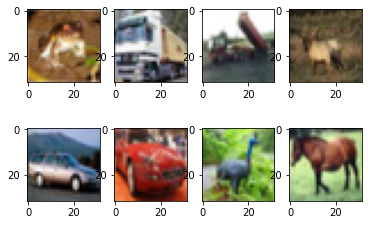

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

The first thing the team conducted was split and reshape the data to feed into the model.

In [7]:
sys.path.insert(0, '../lib')

In [8]:
from split_1 import model_1_split

In [9]:
x_train_1, x_test_1, y_train_1, y_test_1 = model_1_split(n_img, n_noisy, imgs, noisy_labels, clean_labels, np, train_test_split)

In [10]:
# Normalizations
x_train_1=x_train_1/255.0
x_test_1=x_test_1/255.0

In [11]:
# Modify input shape
nsamples,nx,ny,nrgb=x_train_1.shape
x_train_2=x_train_1.reshape((nsamples,nx*ny*nrgb))
nsamples,nx,ny,nrgb=x_test_1.shape
x_test_2=x_test_1.reshape((nsamples,nx*ny*nrgb))

In [12]:
print(x_train_2.shape)
print(x_test_2.shape)

(45000, 3072)
(5000, 3072)


In [13]:
x_train0=x_train_2
x_test0=x_test_2
y_train0=[]
for i in range(len(y_train_1)):
    arr=[0.0]*10
    arr[int(y_train_1[i])]=1.0
    y_train0.append(np.array(arr))
y_train0=np.array(y_train0)
y_test0=[]
for i in range(len(y_test_1)):
    arr=[0]*10
    arr[int(y_test_1[i])]=1.0
    y_test0.append(np.array(arr))
y_test0=np.array(y_test0)

In [14]:
x_train0.shape

(45000, 3072)

In [62]:
x_train0=x_train0.reshape(-1,32,32,3)
x_test0=x_test0.reshape(-1,32,32,3)

The team tested out a convolutional neural network (CNN) a VGG16 model with weights pre-trained on the ImageNet dataset. This model is used as a feature extractor by removing its top (classification) layer, and replacing it with custom layers that will be trained on a new dataset. A batch normalization layer is added on top of the VGG16 model's output to normalize the output of the convolutional layers, a flatten layer is added to convert the output of the batch normalization layer into a vector, and fully connected layer with 128 neurons is added with a ReLU activation function. To help prevent overfitting, a dropout layer is added by randomly setting 40% of the neurons to zero during training.

In [63]:
def create_vgg(X_train,y_train,EPOCHS=20,VS=0.1,BS=128,plot=False):
    sgd=optimizers.SGD(learning_rate=0.001, momentum=0.9)
    temp_model=VGG16(weights='imagenet',pooling="avg",include_top=False,input_shape=(32,32,3))
    temp_model.compile(optimizer=sgd,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    base_out=temp_model.output
    top_fc1=BatchNormalization(name="hidden1")(base_out)
    top_fc2=Flatten(name="flatten")(top_fc1)
    top_fc3=Dense(128,activation="relu",name="hidden2")(top_fc2)
    top_fc4=Dropout(0.4)(top_fc3)
    top_fc5=Dense(10,activation="softmax",name="predictions")(top_fc4)
    model=tf.keras.Model(inputs=temp_model.input, outputs=top_fc5)
    model.compile(optimizer=sgd,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    history=model.fit(X_train, y_train,epochs=EPOCHS,verbose=1,validation_split=VS,batch_size=BS)
    if plot is True:
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(history.history["loss"])
        ax[0].plot(history.history["val_loss"])
        ax[0].title.set_text('Model Loss Function')
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss(Error)")
        ax[0].legend(['training', 'validation'], loc='best')
        
        ax[1].plot(history.history["accuracy"])
        ax[1].plot(history.history["val_accuracy"])
        ax[1].title.set_text('Accuracy function')
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend(['training', 'validation'], loc='best')
    return model

Epoch 1/5
633/633 [==============================] - 835s 1s/step - loss: 2.1843 - accuracy: 0.2463 - val_loss: 2.2021 - val_accuracy: 0.2598
Epoch 2/5
633/633 [==============================] - 903s 1s/step - loss: 2.0669 - accuracy: 0.3333 - val_loss: 2.1199 - val_accuracy: 0.3069
Epoch 3/5
633/633 [==============================] - 799s 1s/step - loss: 2.0230 - accuracy: 0.3660 - val_loss: 2.0410 - val_accuracy: 0.3531
Epoch 4/5
633/633 [==============================] - 809s 1s/step - loss: 1.9979 - accuracy: 0.3811 - val_loss: 2.0261 - val_accuracy: 0.3589
Epoch 5/5
633/633 [==============================] - 820s 1s/step - loss: 1.9654 - accuracy: 0.3978 - val_loss: 2.0637 - val_accuracy: 0.3562


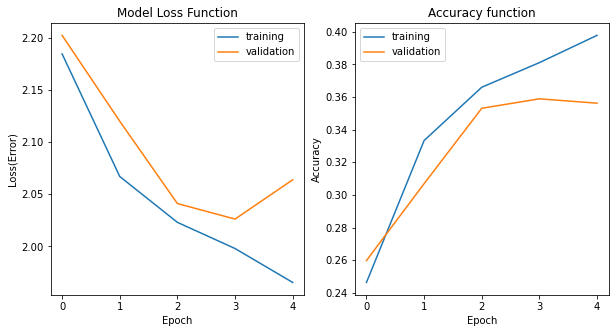

In [64]:
model=create_vgg(x_train0,y_train0,EPOCHS=5,VS=0.1,BS=64,plot=True)

In [66]:
testingv1=model.predict(x_test0)
testingv1=np.array([np.argmax(i) for i in testingv1])
testingv1=to_categorical(testingv1,num_classes=10)

157/157 [==============================] - 9s 54ms/step


In [67]:
cnt=0
for i in range(len(testingv1)):
    for j in range(10):
        if testingv1[i][j]==y_test0[i][j]==1:
            cnt+=1
print(cnt/len(testingv1))

0.3516


Going through several epochs, the model achieved a validation accuracy of 35.1% by treating noisy labels as clean labels.

In [65]:
model.save("../output/model_I.h5")

In [10]:
model1 = tf.keras.models.load_model('../output/model_I.h5')

2023-03-22 18:03:21.733725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    image = np.reshape(image, (1, 32, 32, 3))
    return np.argmax(model1.predict(image, verbose = 0))
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [12]:
t,_,_,_=model_1_split(n_img, n_noisy, imgs, noisy_labels, clean_labels, np, train_test_split)

In [17]:
model_I(t[0])

9

### 2.3. Model II

In [30]:
imgs_clean = imgs[:10000].reshape(-1,3072)

In [31]:
label_arr=random.sample(range(10000),3000)
label_arr.sort()
image_train_clean=[]
image_test=[]
y_train_clean=[]
y_test=[]
y_train_noisy=[]
y_test_noisy=[]
currind=0
for i in range(10000):
    if currind<3000 and label_arr[currind]==i:
        image_test.append(imgs_clean[i])
        y_test.append(clean_labels[i])
        y_test_noisy.append(noisy_labels[i])
        currind+=1
    else:
        image_train_clean.append(imgs_clean[i])
        y_train_clean.append(clean_labels[i])
        y_train_noisy.append(noisy_labels[i])
image_test=np.array(image_test)
image_train_clean=np.array(image_train_clean)
y_train_clean=np.array(y_train_clean)
y_test=np.array(y_test)
y_train_noisy=np.array(y_train_noisy)
y_test_noisy=np.array(y_test_noisy)

In [32]:
y_train_clean=to_categorical(y_train_clean, num_classes = 10)
y_test=to_categorical(y_test,num_classes=10)

In [33]:
y_train_noisy=to_categorical(y_train_noisy, num_classes = 10)
y_test_noisy=to_categorical(y_test_noisy,num_classes=10)

In [34]:
image_train_clean=image_train_clean.reshape(-1,32,32,3)
image_test=image_test.reshape(-1,32,32,3)

In [35]:
image_train_clean=image_train_clean/255.0
image_test=image_test/255.0

In [37]:
from tensorflow.keras.applications.vgg16 import VGG16

We created a label cleaning model which would accept images and noisy labels as input and output predicted clean labels. Data with predicted clean labels will then be fed into the VGG model in Model_I.

The label cleaning model uses VGG16 architecture (pre-trained on the ImageNet dataset) as a feature extractor for the image input. The temp_model variable initializes a VGG16 model with pre-trained weights, but without the top (classification) layers. The base_out variable represents the output from the last layer of the VGG16 model, which is then passed through a dense layer with 128 units and ReLU activation.

For the noisy label input, the model applies a dense layer with 128 units and ReLU activation.

The output from both branches is then concatenated together using the concatenate function. The concatenated output is then passed through two more dense layers, one with 128 units and ReLU activation, and the second with 10 units and softmax activation. The final layer is used for multi-class classification with 10 output classes.

In [39]:
# define two sets of inputs
inputA = tf.keras.Input(shape=(32,32,3))
inputB = tf.keras.Input(shape=(10,))
# the first branch operates on the first input
sgd=optimizers.SGD(learning_rate=0.001, momentum=0.9)
temp_model=VGG16(weights='imagenet',pooling="avg",include_top=False,input_shape=(32,32,3))
temp_model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])
base_out=temp_model.output
x = Dense(128, activation="relu")(base_out)
# the second branch opreates on the second input
y = Dense(128, activation="relu")(inputB)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(128, activation="relu")(combined)
z = Dropout(0.4)(z)
z = Dense(10, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
label_clearing_model = Model(inputs=[temp_model.input, y.input], outputs=z)

Epoch 1/10
50/50 [==============================] - 137s 3s/step - loss: 2.1763 - accuracy: 0.1986 - val_loss: 1.7190 - val_accuracy: 0.4300
Epoch 2/10
50/50 [==============================] - 128s 3s/step - loss: 1.6052 - accuracy: 0.4276 - val_loss: 1.3409 - val_accuracy: 0.5171
Epoch 3/10
50/50 [==============================] - 133s 3s/step - loss: 1.3101 - accuracy: 0.5511 - val_loss: 1.1403 - val_accuracy: 0.6086
Epoch 4/10
50/50 [==============================] - 135s 3s/step - loss: 1.0972 - accuracy: 0.6319 - val_loss: 1.0407 - val_accuracy: 0.6514
Epoch 5/10
50/50 [==============================] - 138s 3s/step - loss: 0.9698 - accuracy: 0.6751 - val_loss: 1.0101 - val_accuracy: 0.6514
Epoch 6/10
50/50 [==============================] - 135s 3s/step - loss: 0.8871 - accuracy: 0.7048 - val_loss: 0.9198 - val_accuracy: 0.6700
Epoch 7/10
50/50 [==============================] - 142s 3s/step - loss: 0.7654 - accuracy: 0.7490 - val_loss: 0.8011 - val_accuracy: 0.7257
Epoch 8/10
50

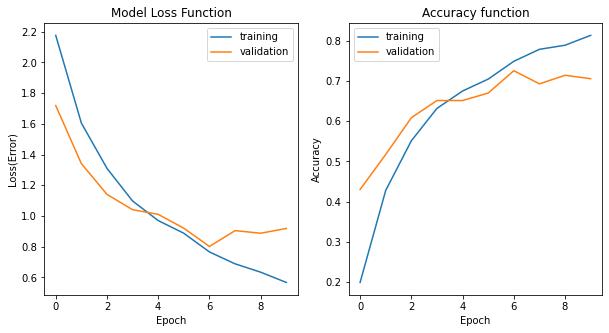

In [40]:
label_clearing_model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])
history=label_clearing_model.fit([image_train_clean,y_train_noisy],y_train_clean,
                                 epochs=10,
                                 verbose=1,
                                 validation_split=0.1,
                                 batch_size=128)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].title.set_text('Model Loss Function')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss(Error)")
ax[0].legend(['training', 'validation'], loc='best')
ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[1].title.set_text('Accuracy function')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend(['training', 'validation'], loc='best')

In [50]:
label_clearing_model.save("label_clearing_model.h5")

In [42]:
noisy_labels_10=to_categorical(noisy_labels[10000:],num_classes=10)

In [43]:
prednoisy=label_clearing_model.predict([imgs[10000:],noisy_labels_10])

1250/1250 [==============================] - 74s 59ms/step


In [44]:
prednoisy=np.array([np.argmax(i) for i in prednoisy])
prednoisy=to_categorical(prednoisy,num_classes=10)

In [45]:
y_train_1=np.concatenate((y_train_clean,prednoisy))

In [46]:
t=imgs[10000:50000]/255

In [47]:
x_train_1=np.concatenate((image_train_clean,t))

Epoch 1/10
331/331 [==============================] - 908s 3s/step - loss: 1.0623 - accuracy: 0.6409 - val_loss: 1.0800 - val_accuracy: 0.6398
Epoch 2/10
331/331 [==============================] - 905s 3s/step - loss: 0.6239 - accuracy: 0.7863 - val_loss: 0.5217 - val_accuracy: 0.8143
Epoch 3/10
331/331 [==============================] - 837s 3s/step - loss: 0.5225 - accuracy: 0.8217 - val_loss: 0.4660 - val_accuracy: 0.8268
Epoch 4/10
331/331 [==============================] - 813s 2s/step - loss: 0.4533 - accuracy: 0.8464 - val_loss: 0.5630 - val_accuracy: 0.7913
Epoch 5/10
331/331 [==============================] - 805s 2s/step - loss: 0.3961 - accuracy: 0.8646 - val_loss: 0.4588 - val_accuracy: 0.8319
Epoch 6/10
331/331 [==============================] - 789s 2s/step - loss: 0.3637 - accuracy: 0.8750 - val_loss: 0.5673 - val_accuracy: 0.8077
Epoch 7/10
331/331 [==============================] - 791s 2s/step - loss: 0.3130 - accuracy: 0.8955 - val_loss: 0.5575 - val_accuracy: 0.8126

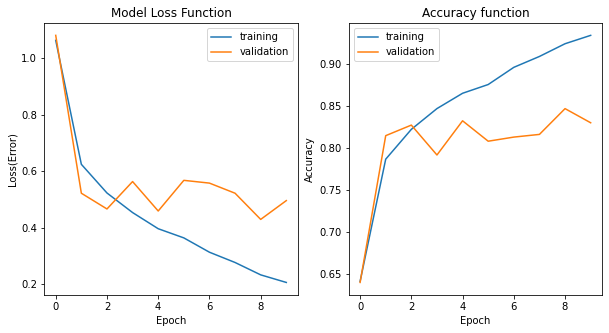

In [49]:
vgg_final=create_vgg(x_train_1,y_train_1,EPOCHS=10,plot=True)

In [51]:
testingv2=vgg_final.predict(image_test)
testingv2=np.array([np.argmax(i) for i in testingv2])
testingv2=to_categorical(testingv2,num_classes=10)

94/94 [==============================] - 6s 60ms/step


In [53]:
cnt=0
for i in range(len(testingv2)):
    for j in range(10):
        if testingv2[i][j]==y_test[i][j]==1:
            cnt+=1
print(cnt/len(testingv2))
#Second Iteration accuracy ??????

0.7016666666666667


The same VGG model tried previously is trained using the new 'cleaned' data. The new model produces a 70% accuracy.

In [54]:
vgg_final.save("../output/final_vgg.h5")

In [18]:
vgg_v2 = tf.keras.models.load_model('../output/final_vgg.h5')

In [19]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    image = np.reshape(image, (1, 32, 32, 3))
    return np.argmax(vgg_v2.predict(image, verbose = 0))

In [20]:
model_II(t[0])

8

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [28]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [ ]:
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [21]:
model1 = tf.keras.models.load_model('../output/model_I.h5')
vgg_v2 = tf.keras.models.load_model('../output/final_vgg.h5')

In [22]:
def model_I(image):
    image = np.reshape(image, (1, 32, 32, 3))
    return np.argmax(model1.predict(image, verbose = 0))

In [23]:
def model_II(image):
    image = np.reshape(image, (1, 32, 32, 3))
    return np.argmax(vgg_v2.predict(image, verbose = 0))

In [24]:
def write_predictions (baseline_model, model_1, model_2, test_imgs):
    column_names = ["Index", "Baseline", "Model I", "Model II" ]
    rows = []
    nimg = test_imgs.shape[0]

    for i in range(nimg):
        rows.append([i,baseline_model(test_imgs[i])[0], model_1(test_imgs[i]), model_2(test_imgs[i])])
        i+=1

    with open('../output/label_prediction.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(column_names)
        for row in rows:
            writer.writerow(row)

In [25]:
def measure_performance(func, *args, **kwargs):
    # Get start time and memory usage
    start_time = time.time()
    start_mem = psutil.Process().memory_info().rss

    # Run the function with the provided arguments and keyword arguments
    func_result = func(*args, **kwargs)

    # Get end time and memory usage
    end_time = time.time()
    end_mem = psutil.Process().memory_info().rss

    # Print results
    print("Function took {} seconds to run.".format(end_time - start_time))
    print("Function used {:.2f} MB of memory.".format((end_mem - start_mem) / (1024 * 1024)))
    print("Total memory available: {:.2f} GB".format(psutil.virtual_memory().total / (1024 * 1024 * 1024)))
    print("CPU usage: {:.2f}%".format(psutil.cpu_percent()))
    
    return func_result

In [32]:
measure_performance(write_predictions, baseline_model, model_I, model_II, test_imgs)

Function took 2381.7928009033203 seconds to run.
Function used 772.59 MB of memory.
Total memory available: 8.00 GB
CPU usage: 57.10%


In [ ]:
measure_performance(evaluation, model_II, test_labels, test_imgs)